In [3]:
import pandas as pd
import numpy as np
from dateutil import parser

#data viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

#google api
from googleapiclient.discovery import build


In [71]:
#NLP libraries
'''
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
!pip install wordcloud
from wordcloud import WordCloud
'''


"\nimport nltk\nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize\nnltk.download('stopwords')\nnltk.download('punkt')\n!pip install wordcloud\nfrom wordcloud import WordCloud\n"

**Data creation with API**

In [4]:
api_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX'

channel_ids = ['UCSpFnDQr88xCZ80N-X7t0nQ',#corridor crew
              'UCYO_jab_esuFRV4b17AJtAw', # 3blue1brown
               'UCzNcnIeuGLXR4uAsJ6cP3kw', #najib elmokhtari
               'UCSHZKyawb77ixDdsGog4iWA', #lex fridman
               'UCHXa4OpASJEwrHrLeIzw7Yg', #Nicholas Renotte
               'UCmtyQOKKmrMVaKuRXz02jbQ', #Sebastian Lague 
              ]
youtube = build('youtube', 'v3', developerKey=api_key)
               

In [19]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request= youtube.channels().list(
        part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute()
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    request = youtube.playlistItems().list(
        part = 'contentDetails',
        playlistId = playlist_id,
        maxResults = 50)
    
    response = request.execute()
    
    video_ids = []
    
     
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50,
                pageToken = next_page_token)
            response = request.execute()
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
            
    return video_ids



def get_video_details(youtube, video_ids):
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)  

    
        

**get channel statistics**


In [10]:
channel_data = get_channel_stats(youtube, channel_ids)

In [11]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Nicholas Renotte,141000,8379104,292,UUHXa4OpASJEwrHrLeIzw7Yg
1,Lex Fridman,2760000,389824362,749,UUSHZKyawb77ixDdsGog4iWA
2,Corridor Crew,6080000,1435913434,1090,UUSpFnDQr88xCZ80N-X7t0nQ
3,Sebastian Lague,1090000,80543353,260,UUmtyQOKKmrMVaKuRXz02jbQ
4,Najib El Mokhtari,271000,9838023,67,UUzNcnIeuGLXR4uAsJ6cP3kw
5,3Blue1Brown,5030000,327512728,128,UUYO_jab_esuFRV4b17AJtAw


In [12]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

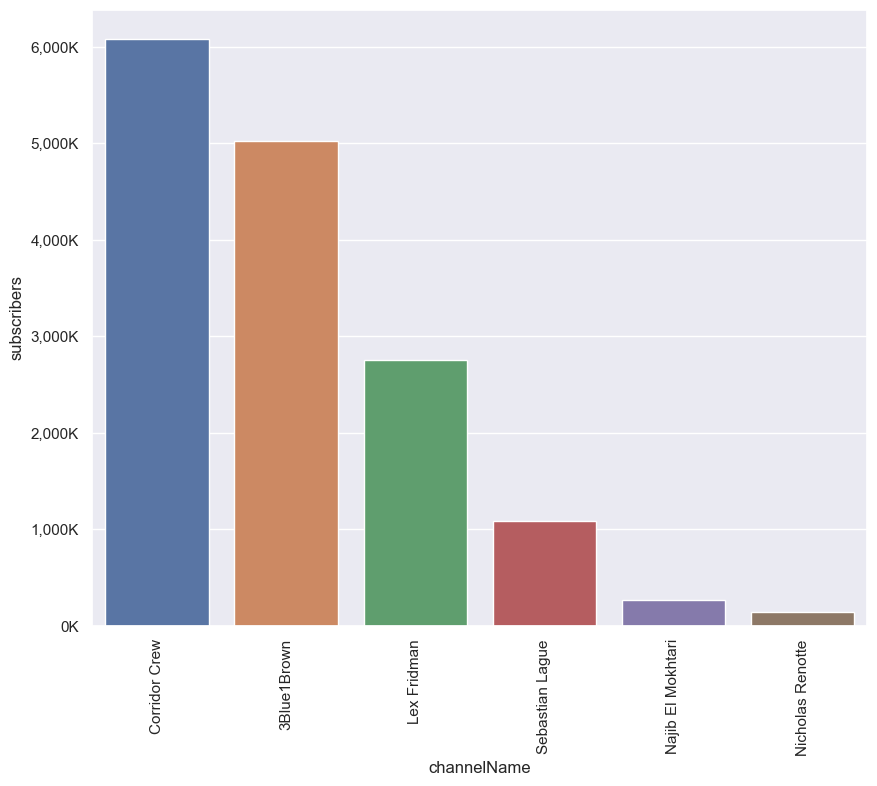

In [13]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

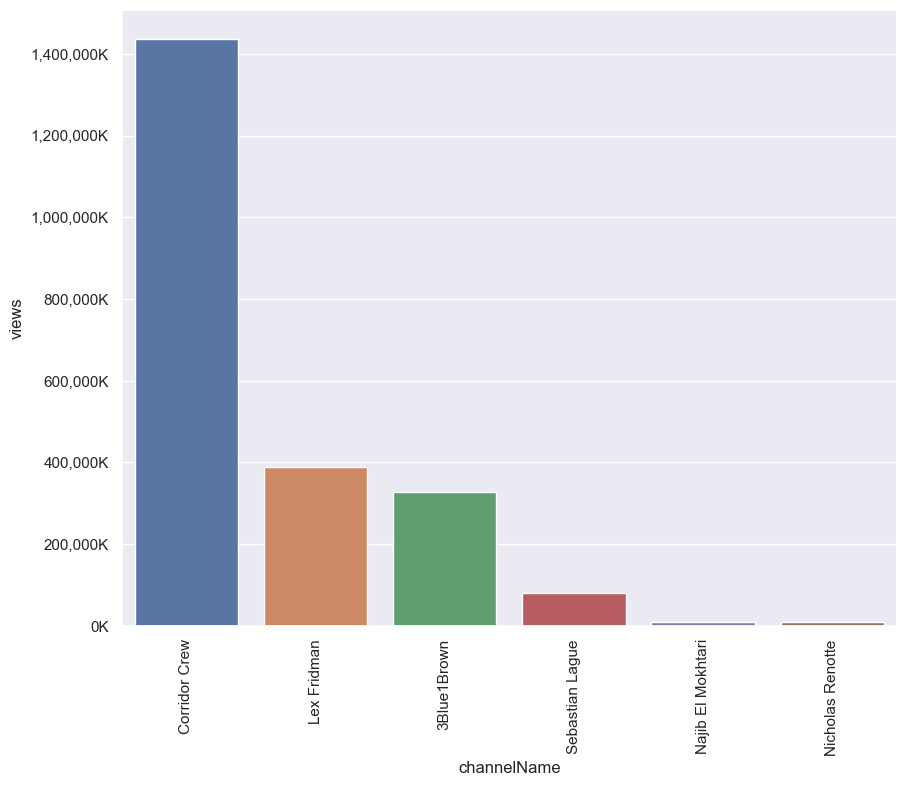

In [15]:
ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

vid statistics for all the channels

In [20]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = video_df.append(video_data, ignore_index=True)
    comments_df = comments_df.append(comments_data, ignore_index=True)

Getting video information from channel: Nicholas Renotte
Could not get comments for video zO1IG8FHSFU


C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Lex Fridman


C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Corridor Crew


C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Sebastian Lague


C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Najib El Mokhtari


C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: 3Blue1Brown


C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\elQajjam Mohammed\AppData\Local\Temp\ipykernel_25232\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


In [21]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,ZGPl3YR0U9E,Nicholas Renotte,Working with the ChatGPT API?!,Get notified of the free Python course on the ...,"[data science, machine learning, deep learning...",2023-03-14T18:53:04Z,4500,196,None,16,PT51M6S,hd,false
1,pekEMLmYx34,Nicholas Renotte,"I'm giving away a FREE GPU, it's a 40**!?!",Sign up for GTC here: \nhttps://nvda.ws/3QXH97...,None,2023-03-14T03:01:10Z,6773,606,None,49,PT44S,hd,false
2,RF53NPPhBmE,Nicholas Renotte,Do you ACTUALLY NEED math for Machine Learning?,Get notified of the free Python course on the ...,None,2023-03-09T01:42:33Z,8426,669,None,27,PT51S,hd,false
3,ZkFKF-ohsKk,Nicholas Renotte,How to use the ChatGPT API with Python!!,Get notified of the free Python course on the ...,None,2023-03-07T04:26:42Z,29162,1870,None,54,PT49S,hd,false
4,FMPYShYLg3o,Nicholas Renotte,How to Code a Machine Learning Lip Reading App...,Get notified of the free Python course on the ...,"[machine learning, python, ai]",2023-02-26T03:02:28Z,7433,375,None,75,PT45M25S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,-9OUyo8NFZg,3Blue1Brown,Euler's Formula and Graph Duality,"A description of planar graph duality, and how...","[three brown one blue, Leonhard Euler (Academi...",2015-06-21T06:05:43Z,429005,10206,None,338,PT7M27S,hd,true
2583,K8P8uFahAgc,3Blue1Brown,Circle Division Solution,An explanation of a neat circle puzzle involvi...,"[Moser's Circle Problem, 3 brown 1 blue, Euler...",2015-05-24T05:25:09Z,529663,15963,None,639,PT8M53S,hd,true
2584,84hEmGHw3J8,3Blue1Brown,A Curious Pattern Indeed,A teaser for some future videos regarding a pa...,"[3 blue 1 brown, geometry, 3brown1blue, three ...",2015-04-11T08:19:03Z,515339,10608,None,208,PT1M49S,hd,true
2585,zLzLxVeqdQg,3Blue1Brown,Euler's Formula Poem,"A poem about why e to the pi i equals -1, base...","[3 brown 1 blue, 3 blue 1 brown, three brown o...",2015-03-05T06:15:23Z,147717,4562,None,139,PT1M4S,hd,true


In [23]:
comments_df

,video_id,comments
0,ZGPl3YR0U9E,"[Missed this live, unfortunately it was midnig..."
1,pekEMLmYx34,[This looks awesome! Thanks for doing this nic...
2,RF53NPPhBmE,"[hey nicholas please made video on kaggle, I u..."
3,ZkFKF-ohsKk,[Hi there. Is it possible you could tell me if...
4,FMPYShYLg3o,"[don't know if u still remember me, but two ye..."
...,...,...
2581,-9OUyo8NFZg,[So the spanning tree of a graph has no cycle ...
2582,K8P8uFahAgc,[Great video! Maybe we can replace 1 by n choo...
2583,84hEmGHw3J8,[I just noticed that at 31 there appears an ar...
2584,zLzLxVeqdQg,[sing this to the tune of chopin etude op 25 n...


In [24]:
#write video data to CSV file 
video_df.to_csv('video_data.csv')
comments_df.to_csv('comments_data.csv')

**Preprocessing & Feature engineering**

check for empty  values

In [25]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [27]:
video_df.publishedAt.sort_values().value_counts()

2016-09-27T17:47:35Z    10
2019-09-24T17:29:41Z     3
2019-12-13T14:29:47Z     3
2019-12-12T14:29:55Z     3
2019-11-09T18:57:09Z     3
                        ..
2018-01-31T18:00:05Z     1
2018-02-02T18:00:01Z     1
2018-02-03T22:18:16Z     1
2018-02-05T18:00:02Z     1
2023-03-18T16:00:12Z     1
Name: publishedAt, Length: 2539, dtype: int64

In [29]:
cols = ['viewCount', 'likeCount',  'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

Enriching data

In [30]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [35]:
# convert duration to seconds
!pip install isodate
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [37]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [38]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [39]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,ZGPl3YR0U9E,Nicholas Renotte,Working with the ChatGPT API?!,Get notified of the free Python course on the ...,"[data science, machine learning, deep learning...",2023-03-14 18:53:04+00:00,4500.0,196.0,None,16.0,PT51M6S,hd,false,Tuesday,3066.0,5,43.555556,3.555556,30
1,pekEMLmYx34,Nicholas Renotte,"I'm giving away a FREE GPU, it's a 40**!?!",Sign up for GTC here: \nhttps://nvda.ws/3QXH97...,None,2023-03-14 03:01:10+00:00,6773.0,606.0,None,49.0,PT44S,hd,false,Tuesday,44.0,0,89.472907,7.234608,42
2,RF53NPPhBmE,Nicholas Renotte,Do you ACTUALLY NEED math for Machine Learning?,Get notified of the free Python course on the ...,None,2023-03-09 01:42:33+00:00,8426.0,669.0,None,27.0,PT51S,hd,false,Thursday,51.0,0,79.397104,3.204367,47
3,ZkFKF-ohsKk,Nicholas Renotte,How to use the ChatGPT API with Python!!,Get notified of the free Python course on the ...,None,2023-03-07 04:26:42+00:00,29162.0,1870.0,None,54.0,PT49S,hd,false,Tuesday,49.0,0,64.124546,1.851725,40
4,FMPYShYLg3o,Nicholas Renotte,How to Code a Machine Learning Lip Reading App...,Get notified of the free Python course on the ...,"[machine learning, python, ai]",2023-02-26 03:02:28+00:00,7433.0,375.0,None,75.0,PT45M25S,hd,false,Sunday,2725.0,3,50.450693,10.090139,83


**EDA**

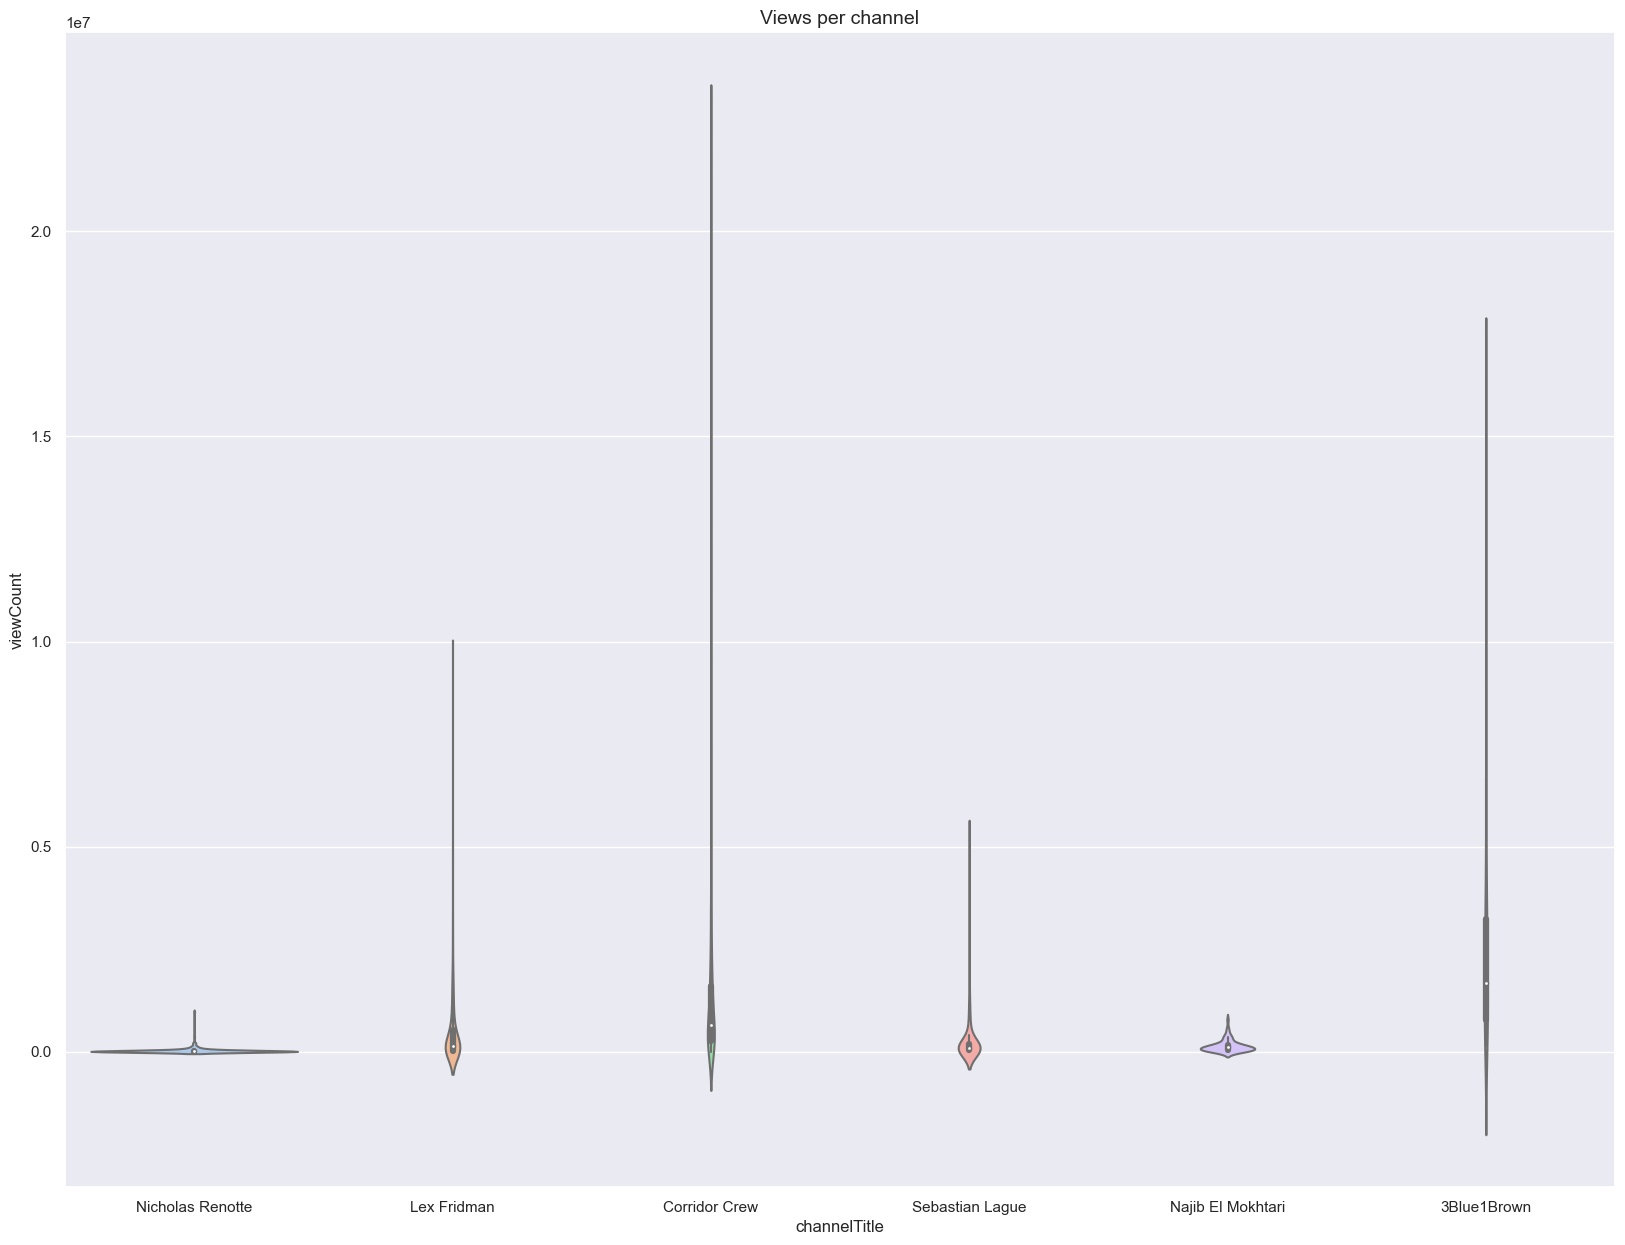

In [51]:
plt.rcParams['figure.figsize'] = (20, 15)
sns.violinplot(data = video_df,x = video_df['channelTitle'], y = video_df['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

Does the number of likes and comments matter for a video to get more views?

<AxesSubplot: xlabel='likeCount', ylabel='viewCount'>

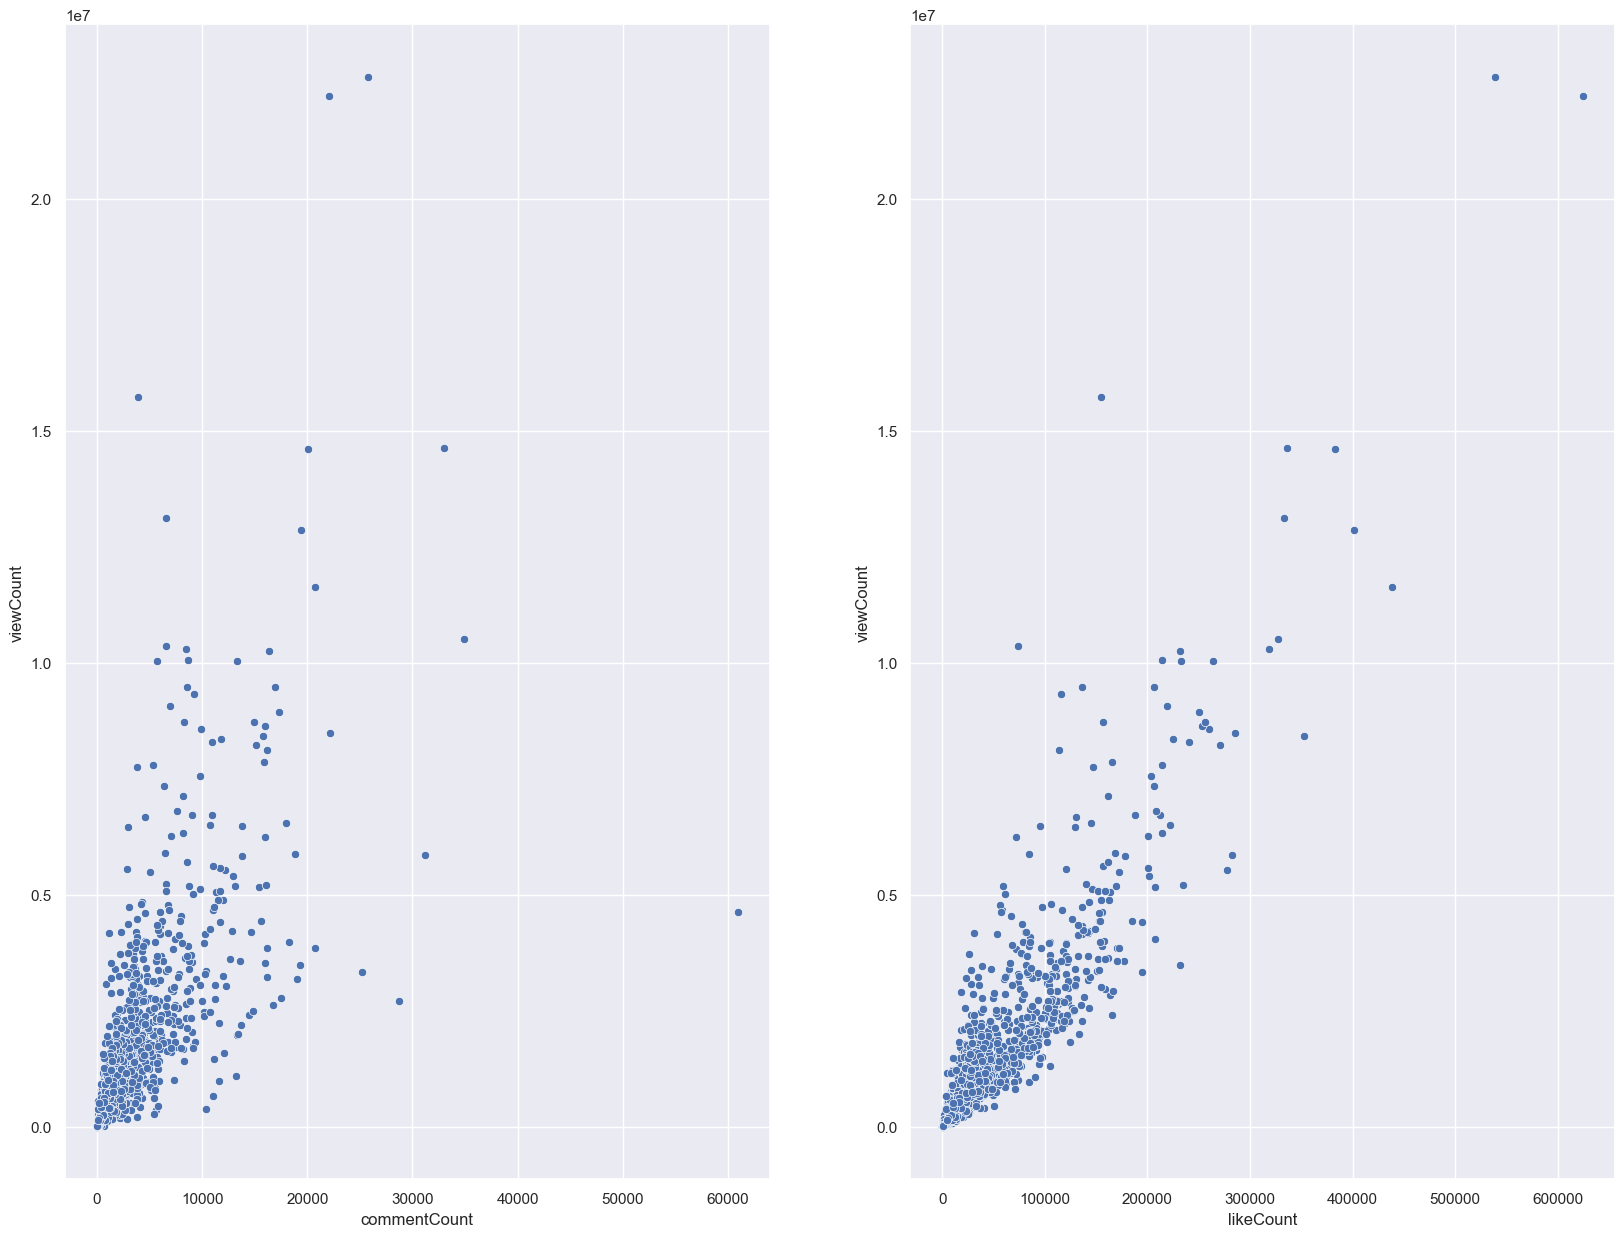

In [52]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

<AxesSubplot: xlabel='likeRatio', ylabel='viewCount'>

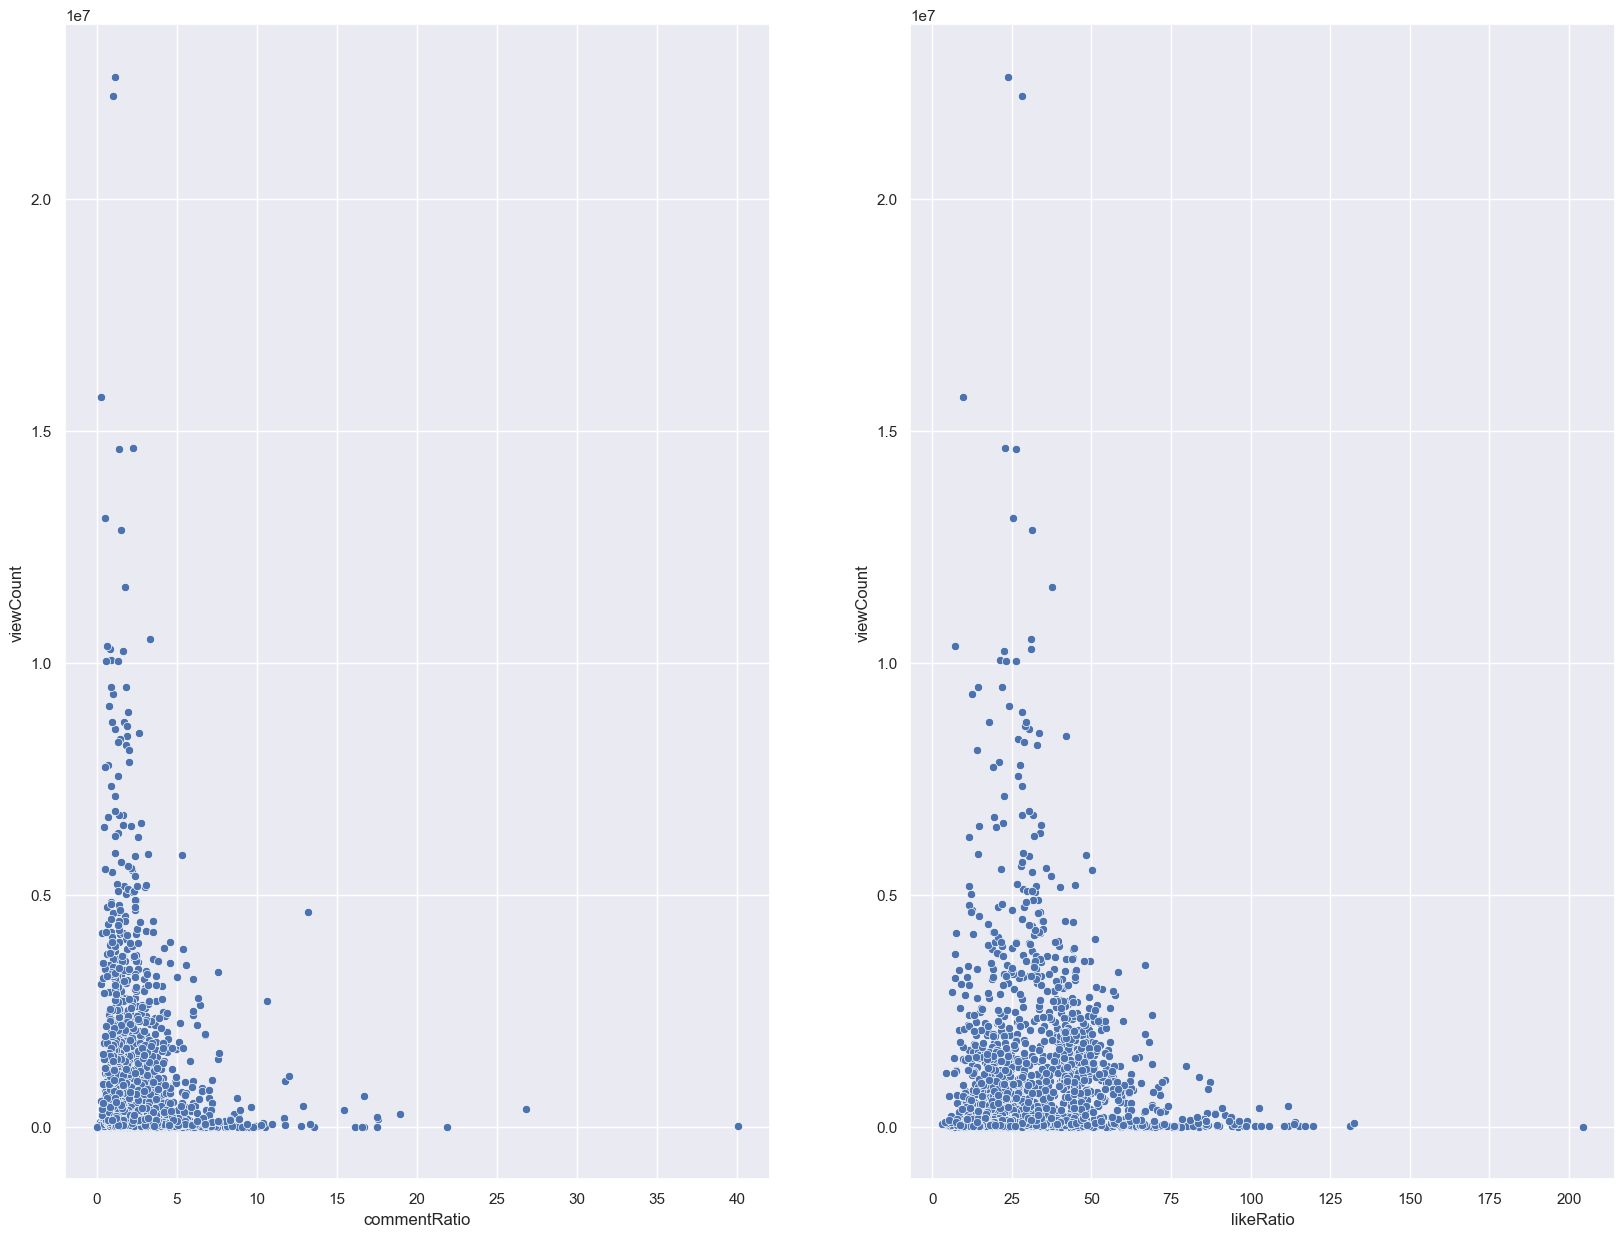

In [53]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

Does the video duration matter for views and interaction (likes/ comments)?

<AxesSubplot: xlabel='durationSecs', ylabel='Count'>

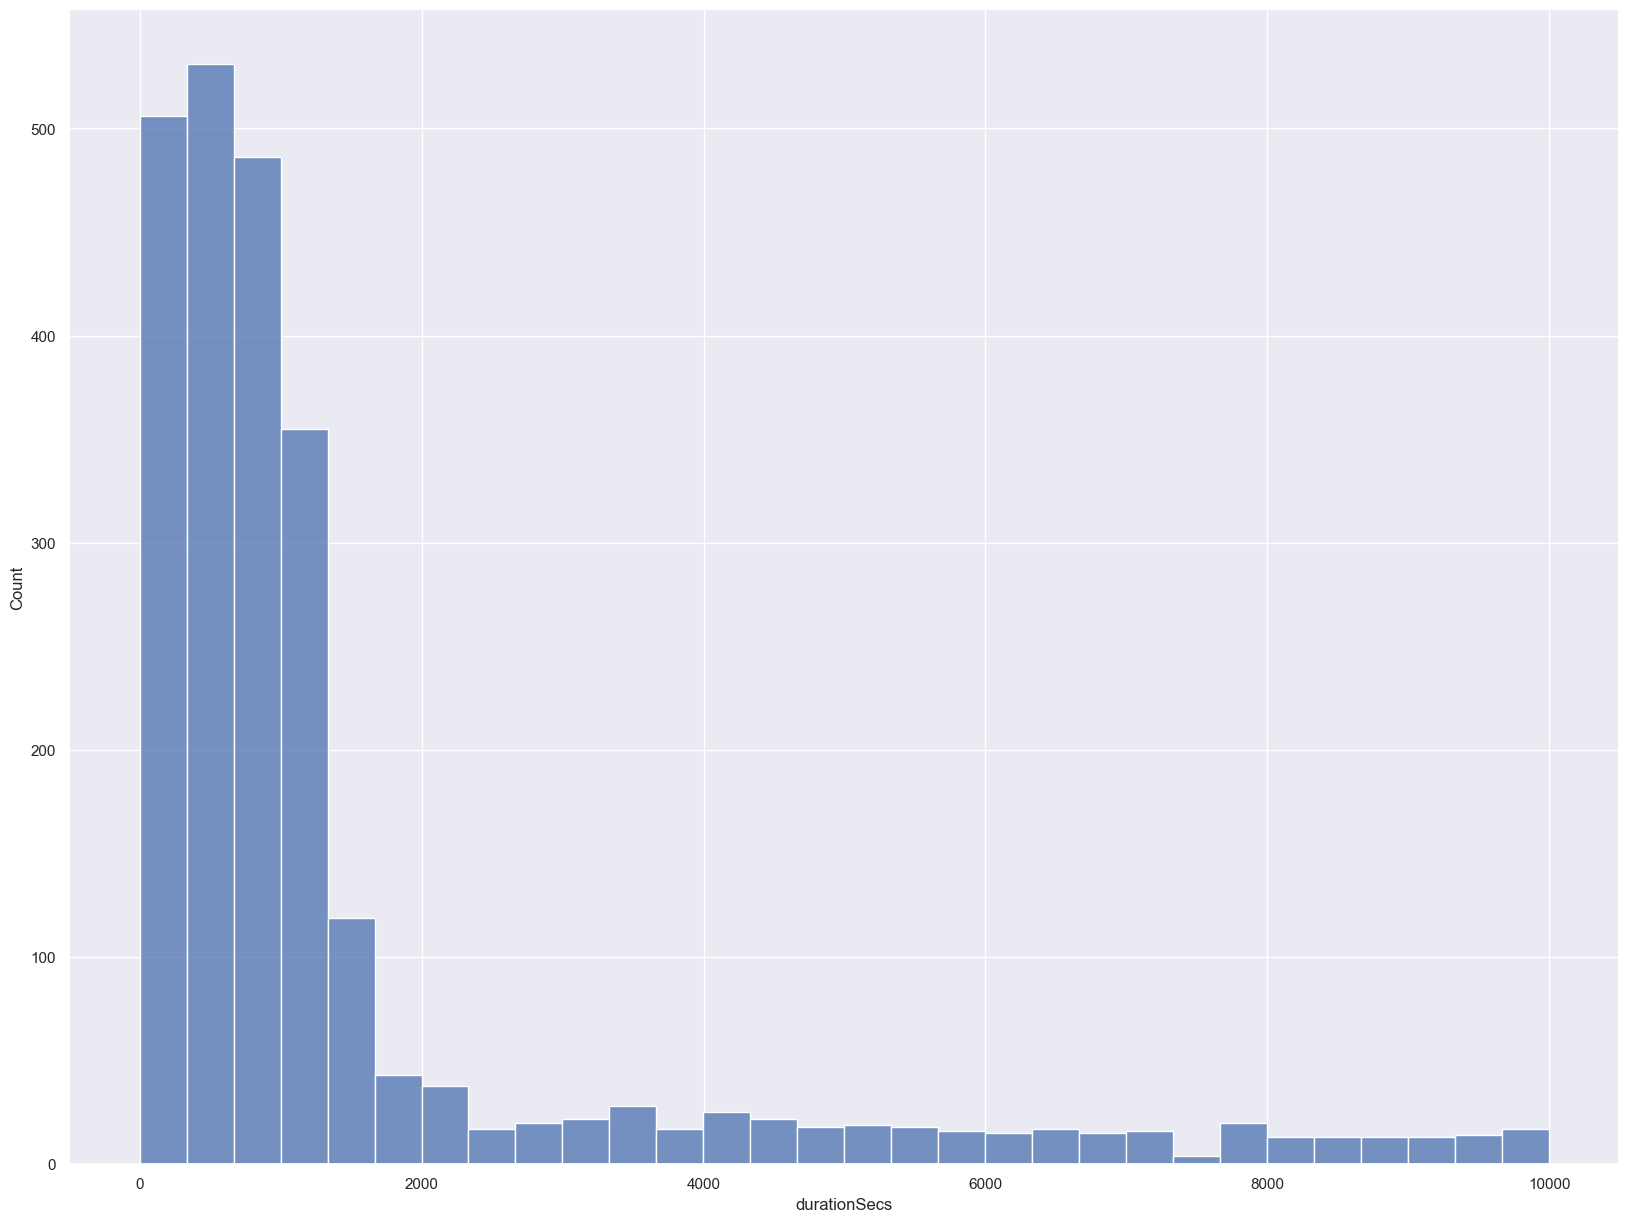

In [54]:
sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)

<AxesSubplot: xlabel='durationSecs', ylabel='likeCount'>

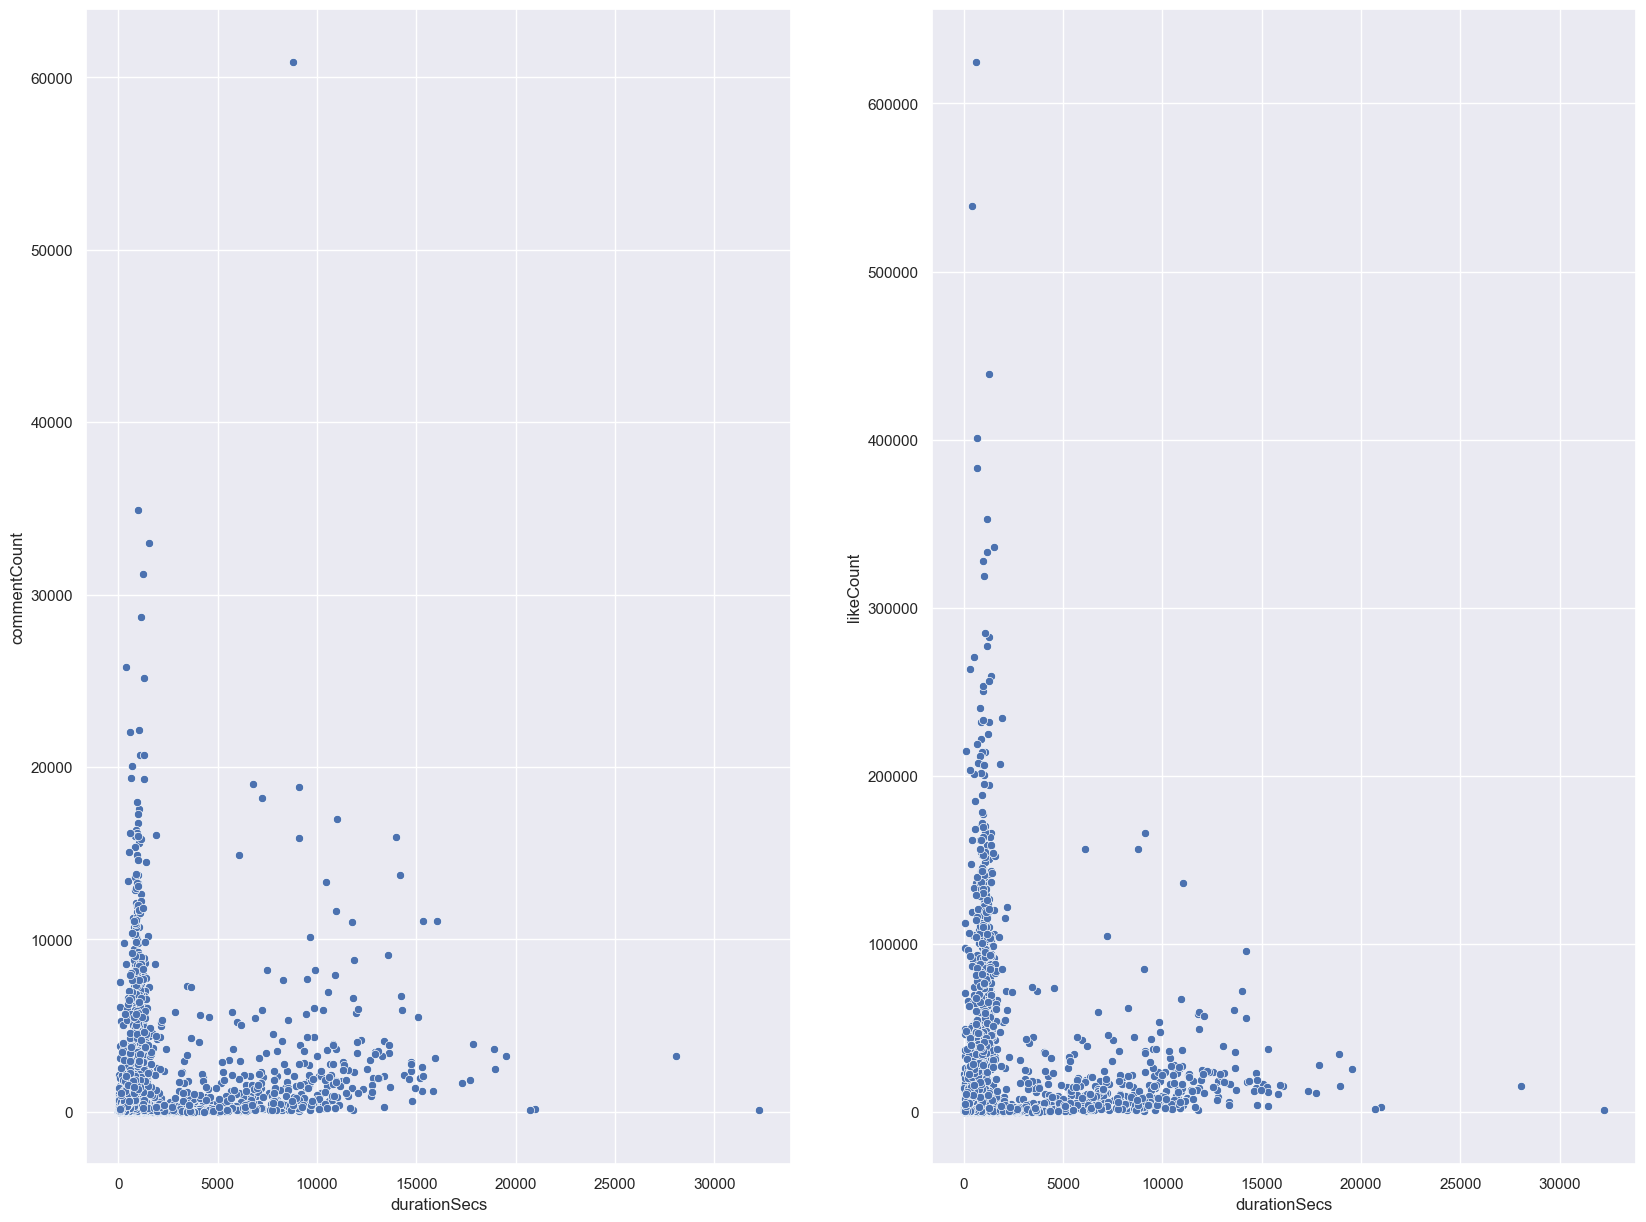

In [55]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

Does title length matter for views?

<AxesSubplot: xlabel='titleLength', ylabel='viewCount'>

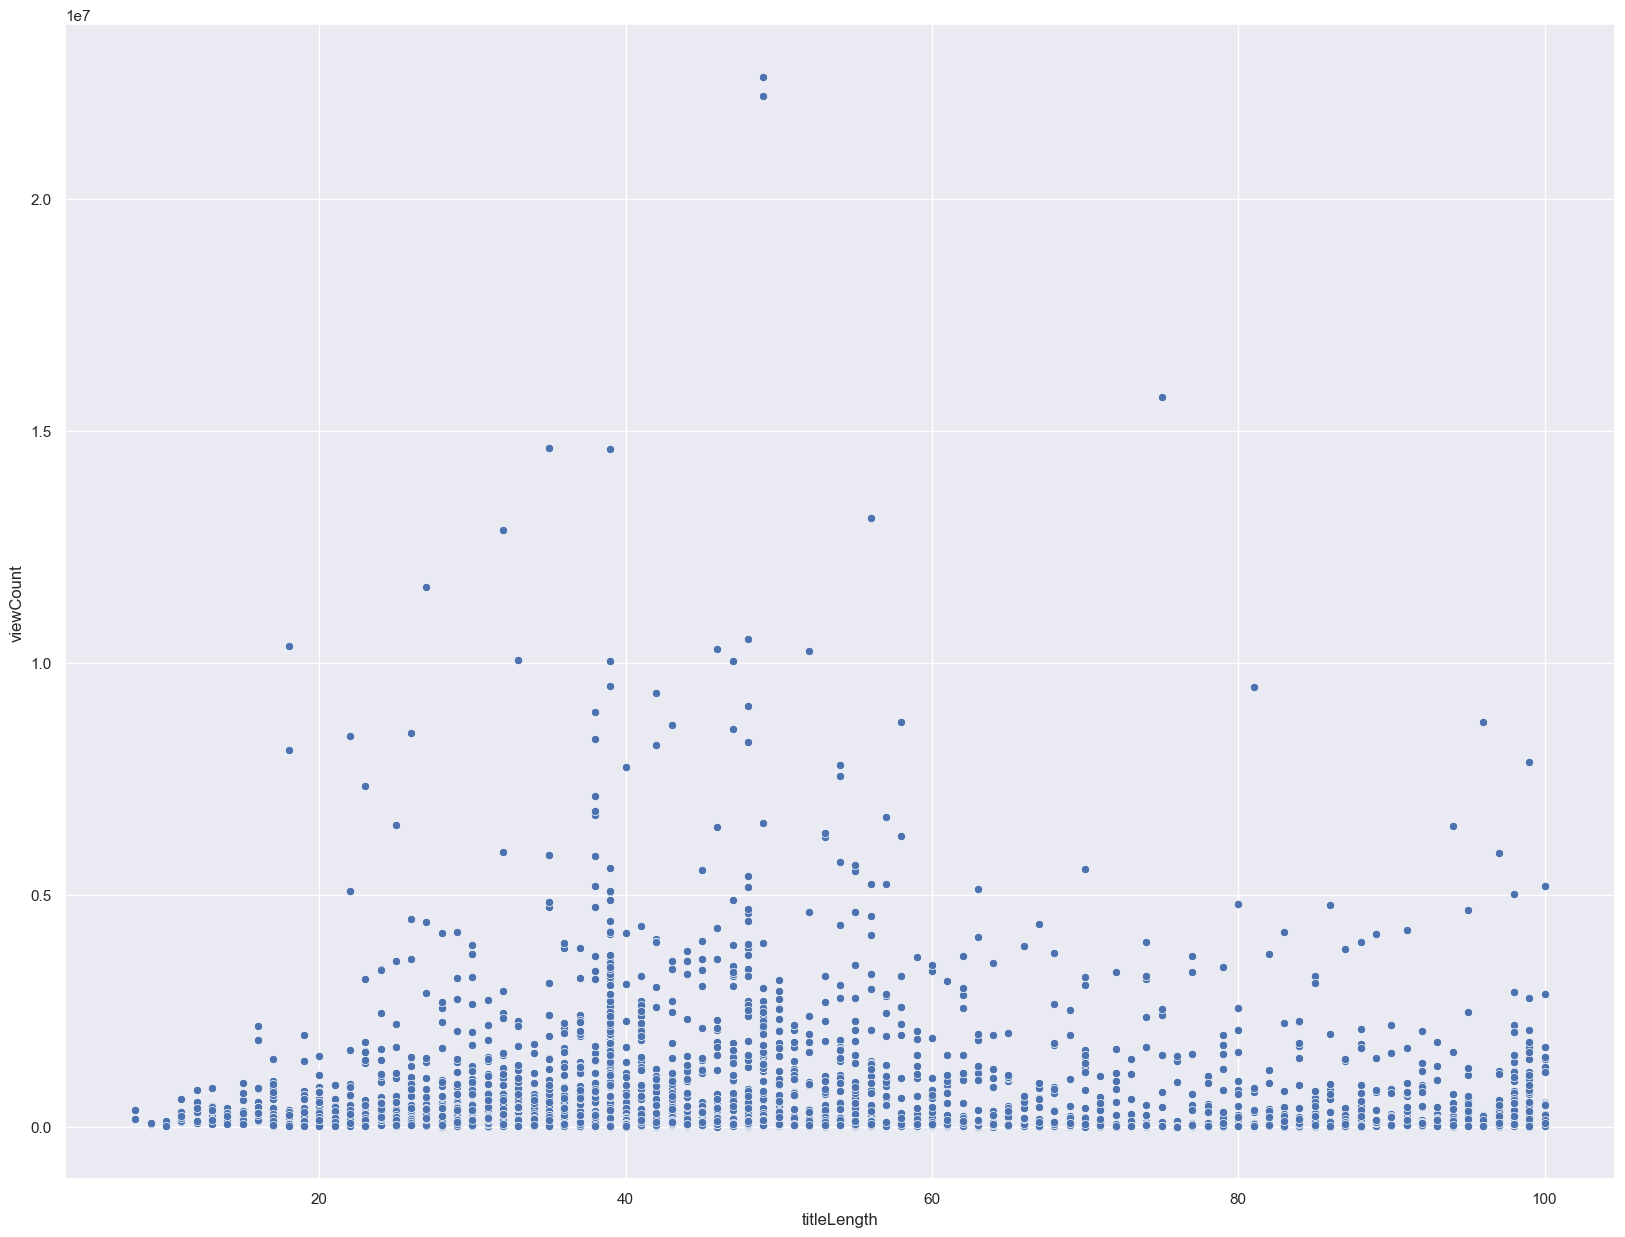

In [57]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

**Wordcloud for words in title**

In [72]:
'''
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)
'''


"\nstop_words = set(stopwords.words('english'))\nvideo_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])\n\nall_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])\nall_words_str = ' '.join(all_words)\n"

In [73]:

'''
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");
from wordcloud import WordCloud
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)
'''


'\ndef plot_cloud(wordcloud):\n    plt.figure(figsize=(30, 20))\n    plt.imshow(wordcloud) \n    plt.axis("off");\nfrom wordcloud import WordCloud\nwordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color=\'black\', \n                      colormap=\'viridis\', collocations=False).generate(all_words_str)\nplot_cloud(wordcloud)\n'